# Overview

The aim of this project is to classify a set text documents which has labels only for a small subset of the samples. Combing unsupervised soft clustering (topic modelling via LDA) with descriminative classiferies trained on the output imbeddings, the goal is to achieve high classifcation accuracy with as few labels as possible. 


In [24]:
''' Track all imported libraries here '''

import os
import string
from itertools import islice
import pprint

# Notebooks
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings('ignore')
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from IPython.display import display_html 

# Data analytics
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# NLP
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('all')
from nltk.corpus import wordnet

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC


# Visualisations
from matplotlib import pyplot as plt
import seaborn as sns

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp

[nltk_data]    |   Unzipping corpora/sentiwordnet.zip.
[nltk_data]    | Downloading package sentence_polarity to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/sentence_polarity.zip.
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/shakespeare.zip.
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/sinica_treebank.zip.
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/smultron.zip.
[nltk_data]    | Downloading package state_union to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/state_union.zip.
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     /Users/amccart9/nltk_data...
[nltk_data]    |   Unzipping corpora/stopwords.zip.

# 1. Data Exploration
## 1.1 File Structure
Converting directory trees into something useable.
<hr>


In [6]:
'''Data structure; train and test directories each contain 20 folders. Each
   folder contains data samples of the same class'''


test  = '/Users/Projects/newsdata/20news-bydate-test'
train = '/Users/Projects/20news-bydate-train'

'''Create inteer mapping for class labels'''
classes = {i : os.listdir(test)[i] for i in range(0, len(os.listdir(test)))}
print("Data class mappings: ", classes)

Data class mappings:  {0: 'talk.politics.mideast', 1: 'rec.autos', 2: 'comp.sys.mac.hardware', 3: 'alt.atheism', 4: 'rec.sport.baseball', 5: 'comp.os.ms-windows.misc', 6: 'rec.sport.hockey', 7: 'sci.crypt', 8: 'sci.med', 9: 'talk.politics.misc', 10: 'rec.motorcycles', 11: 'comp.windows.x', 12: 'comp.graphics', 13: 'comp.sys.ibm.pc.hardware', 14: 'sci.electronics', 15: 'talk.politics.guns', 16: 'sci.space', 17: 'soc.religion.christian', 18: 'misc.forsale', 19: 'talk.religion.misc'}


<hr>Note that the train test split was designed by the dataset owner. The spit is across some interval of time, with only train samples before a certain date, and only test samples after that date.

In [11]:
'''Collapse file structure in train and test, renaming samples to reflect class label'''


# New directories
train = 'data/train'
test  = 'data/test'

# Flatten file structure, and save files in new directory
def flatten_directories(parent_dir, new_dir):
    
    data = []
    for i in os.listdir(parent_dir):
        files = [parent_dir + '/' + i + '/' + j for j in list(filter(lambda f: not f.startswith('.'), os.listdir(parent_dir + '/' + i)))]
        data.extend(files)

    for i in data:
        os.rename(i, new_dir + '/' + str(i.split('/')[-2]) + '_' + str(i.split('/')[-1]) + '.txt') 

flatten_directories(test , clean_test) 
flatten_directories(train, clean_train)

## 1.2 Dirty Data

Let's take a look at an example of the data, and the various artifacts that appear within.
<hr>

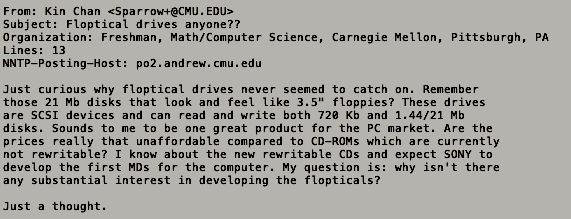

In [13]:
from IPython.display import Image
Image(filename='image.png') 

The data contains From and Subject blocks, which will skew results. Email addresses with .edu suffices, and organisation names will all confuse the models. Further, text dermaked with the ">" symbol represents text from other posts to which the current forum user is responding (there are many different repsonse demarkation symbols). These have to be removed, because multiple data points might respond to the same post. Finally, the signature at the end contains irrelevant and misleading text which ought to be removed.

<hr>

## 1.3 Cleaning the Data
Remove the artifacts of the data. Regex can take care of the comment response duplication issue, as well as the headers. As there is significant variety in the signatures, (some posts have simple signatures, some have complicated signatures, some have none, and some posts use common signature symbols throughout their post), the signatures will be untouched. Note that an approximate removal of the artifacts is all that's actually required; the TF-IDF emebeddings that will be used later will select only those tokens which are of importance (i.e. frequency above some threshold) anyway.
<hr>

In [14]:
# Cleanse all input files and write back the changes
def remove_artifacts(input_dir):
    
    data_set = [input_dir + '/' + i for i in list(filter(lambda f: not f.startswith('.'), os.listdir(input_dir)))]
    for text_file in data_set:
    
        with open(text_file, 'r', encoding="latin-1") as f: # Encoding required for strange forum characters
            dirty_text = f.readlines()
        header     = "^[\w-]+:" # All post headers
        response   = "^>|^#|^:|^\|" # Text demarked as source of response post
        reply_ref  = "^In article <|\w+\s(writes|wrote):$|\)\s(writes|wrote):$" # Other artifacts
        clean_text = []

        # If any line in file contains artifact, remove it
        for line in dirty_text:
            match_1  = re.findall(header   , line)
            match_2  = re.findall(response , line)
            match_3  = re.findall(reply_ref, line)
            if match_1 or match_2 or match_3:
                clean_text.append('')   
            else:
                clean_text.append(line)
        
        with open(input_dir + '/' + text_file.split('/')[-1], 'w') as f:
            f.write(''.join(clean_text).replace('\n\n\n', '\n').replace('\n\n', '\n'))

remove_artifacts(clean_train)
remove_artifacts(clean_test)




## 1.4 Structuring the Data
Store the data in dataframes and create numeric class labels.
<hr>

In [15]:
'''Build each row of dataframe by reading text files and pulling out relevant data'''

columns = ['text', 'class', 'source']

def files_to_rows(directory, source):
    files = [directory + '/' + i for i in list(filter(lambda f: not f.startswith('.'), os.listdir(directory)))]
    
    rows = []
    for file in files:
        with open(file, 'r') as f:
            text = f.read()
        class_name = file.split('/')[-1].split('_')[0]
        class_     = list(classes.keys())[list(classes.values()).index(class_name)]
        rows.append([text, class_, source])
    return rows
        

df_train = pd.DataFrame(files_to_rows(clean_train, 'train'), columns=columns)
df_test  = pd.DataFrame(files_to_rows(clean_test , 'test'), columns=columns)
df_full  = pd.concat([df_train, df_test])
print("{} records.".format(df_full.shape[0]))
df_full.head()

18846 records.


,text,class,source
0,\n} >>\n} >>>Has Jack lost a bit of his edge? ...,4,train
1,\nI am involved with a Michigan company that h...,14,train
2,\nThere are several public domain utilities av...,12,train
3,\nWhat's the problem here? Back in 1958 I rod...,10,train
4,"\n""Through a single data point, you can draw a...",1,train


## 1.5 Exploring the Data
With all that leg work out of the way, let's look at the interesting stuff.
<hr>

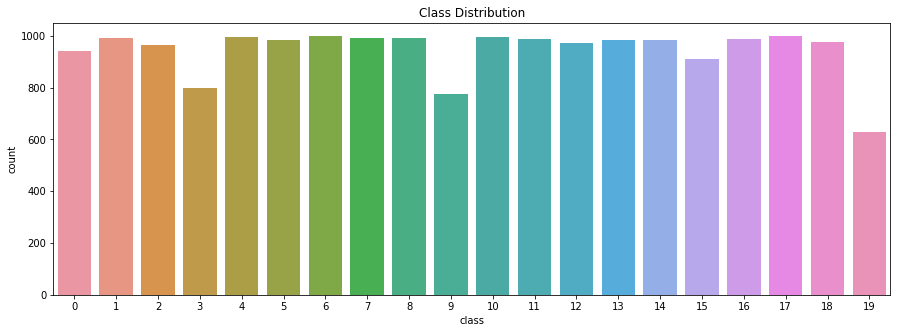

In [16]:
'''Check for class imbalance in the dataset'''

plt.figure(figsize=(15,5))
plt.title("Class Distribution")
ax = sns.countplot(x="class", data=df_full)

Okay, the classes have a little bit of imbalance. A bit of upsampling may be required down the line.
<hr>

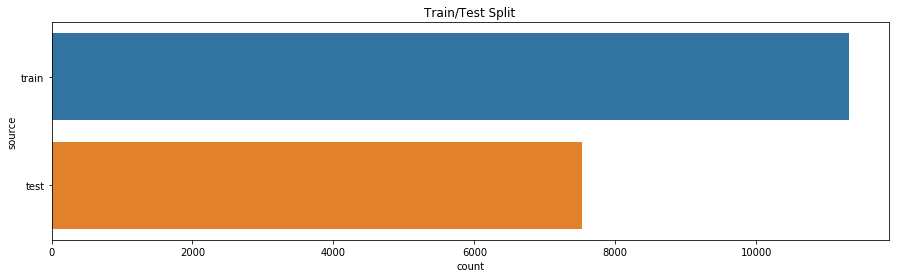

In [17]:
'''Train/Test Split'''
plt.figure(figsize=(15, 4))
plt.title("Train/Test Split")
sns.set_color_codes("pastel")
ax = sns.countplot(y="source", data=df_full)


<hr>

## 2.1 Building out NLP Tools
Before pushing into the juicy parts of machine learning (model training), we must convert the text data into something that the classifers can understand. So, let's create a couple of utility functions. It's necessary to control all data processing between all experimental methods, to minimise experimental error. As the topic modelling will require the Gensim library, and Sklearn will take the rest, we'll have to create standardised TF-IDF dictionaries between each library.
<hr>

In [20]:
'''Utility Functions'''


# Feed a word (with POS tag), return the lemmatization and the stem of the word
def lemmatize_and_stem(word, pos_tag=wordnet.NOUN):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(word, pos=pos_tag))


# Feed a phrase, return list of tuples, each containing a word from phrase and POS tag
def tag_POS(phrase):
    phrase = nltk.word_tokenize(phrase)
    phrase = nltk.pos_tag(phrase)
    return phrase


# Separate contractions so that each word gets its own tag (NLTK can be clumsy if you
# don't do this!)
def remove_contraction(phrase):
    expansions = {r"he's"  : "he is"   , r"she's": "she is", r"it's" : "it is" ,
                r"let's"  : "let us"  , r"n\'t" : " not"  , r"\'re" : " are"  ,
                r"\'d"    : " would"  , r"\'ll" : " will" , r"\'t"  : " not"  ,
                r"\'ve"   : " have"   , r"\'m"  : " am"}
    for k in expansions:
        phrase = re.sub(k, expansions[k], phrase)
    return(phrase)


# Feed POS tag from NLTK, convert it to be usable by wordnet
def get_wordnet_pos(treebank_tag):
    initial = treebank_tag[0]
    convert = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R' : wordnet.ADV}
    try:
        return convert[initial]
    except:
        return wordnet.NOUN # Default of lemmatizer argument


# Feed a string, return a list of of lemmatized, stemmed words from that string
def prepare_text_data(text):
    result = []
    tokens = []
    
    text = tag_POS(remove_contraction(text.lower()))
    
    for token in text:
        tokens.append((token[0], get_wordnet_pos(token[1])))

    for token in tokens:
        if token[0] not in gensim.parsing.preprocessing.STOPWORDS and len(token[0]) >= 3:
            result.append(lemmatize_and_stem(token[0], token[1]))
        
    return(result)

The above utility functions convert all words into their root form. The NLTK library is used to mark POS of the text data, to ensure accurate lemmatizing. By default the Wordnet library lemmatizes with the presumption that the word is a verb. This in innaccurate in many cases in English. 
For example, 'rose' the verb lemmatizes to 'rise', whereas 'rose' the noun lemmatizes to 'rose'. Also, it is necessary to convert from NLTK-standard tagging to Wordnet-standard.
<hr>

In [25]:
'''Testing the data processing utility functions'''

# Take a random datapoint
sample = df_train.text[3000]
    
print('Unprocessed sample: \n\n', sample)
print('Processed sample: \n\n', prepare_text_data(sample))

Unprocessed sample: 

 
Anyone out there in netland have a spare data pod or two from an old 
1615A Hewlett Packard logic analyzer?  If you do, I'd like to buy it off
of you.  The pod's part number is 10248B.
As a side note, anyone know of any good surplus dealer or other organization
that would carry wayward logic analzer pods?
				Thanks a byte,
						Tod
							tod@cco.caltech.edu

Processed sample: 

 ['netland', 'spare', 'data', 'pod', 'old', '1615a', 'hewlett', 'packard', 'logic', 'analyz', 'like', 'buy', 'pod', 'number', '10248b', 'note', 'know', 'good', 'surplu', 'dealer', 'organ', 'carri', 'wayward', 'logic', 'analz', 'pod', 'thank', 'byte', 'tod', 'tod', 'cco.caltech.edu']


In [26]:
'''Apply processing to entire dataset'''

# progress_map() is the tqdm equivalent of pandas.DataFrame.map()
# prepared_train = df_train['text'].progress_map(prepare_text_data)#.to_frame().merge(df_train[['class']], left_index=True, right_index=True)
# prepared_test  =  df_test['text'].progress_map(prepare_text_data)#.to_frame().merge(df_test[['class' ]], left_index=True, right_index=True)


In [32]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [35]:
df_train['processed_text'] = df_train['text'].parallel_apply(lambda x: prepare_text_data(x))
df_test['processed_text'] = df_test['text'].parallel_apply(lambda x: prepare_text_data(x))
df_train.head()

,text,class,source,processed_text
0,\n} >>\n} >>>Has Jack lost a bit of his edge? ...,4,train,"[jack, lose, bit, edg, bad, start, jack, morri..."
1,\nI am involved with a Michigan company that h...,14,train,"[involv, michigan, compani, applic, requir, wi..."
2,\nThere are several public domain utilities av...,12,train,"[public, domain, util, avail, usual, archiv, s..."
3,\nWhat's the problem here? Back in 1958 I rod...,10,train,"[problem, 1958, ride, puch, 175, pari, barcelo..."
4,"\n""Through a single data point, you can draw a...",1,train,"[singl, data, point, draw, line, want, dr., ba..."


In [39]:
''' Build a vocabulary for encoding text data'''

def generate_vocabulary(corpus):
    dic = gensim.corpora.Dictionary(corpus) # Create integer ID for each token in corpus
    dic.filter_extremes(no_below=2, no_above=0.5, keep_n=30000)
    # Remove any 'dirty' tokens, like email addresses, and swap k:v pairs for integration with sklearn
    dic = {v: k for k, v in dic.iteritems() if not any([x in v for x in string.punctuation])}
    for i, k in enumerate(dic.keys()): # Reset value IDs (want consecutive integers from 0)
        dic[k] = i
    return(dic)
    
dic_train = generate_vocabulary(df_train['processed_text'])
dic_test = generate_vocabulary(df_test['processed_text'])
print("Feature count: \n\nTrain: {}.\nTest: {}.".format(len(dic_train), len(dic_test)))


Feature count: 

Train: 21634.
Test: 19074.


In [40]:
''' Have a look at what the dictionaries are storing'''
from itertools import islice
print(list(islice(dic_train, 100)))

['6th', 'age', 'ago', 'appar', 'averag', 'bad', 'base', 'basebal', 'basic', 'believ', 'best', 'bit', 'boston', 'care', 'catch', 'charl', 'cheap', 'choic', 'come', 'compar', 'contribut', 'count', 'curiou', 'damn', 'divis', 'easili', 'edg', 'enjoy', 'expect', 'fame', 'far', 'finger', 'finish', 'frank', 'futur', 'game', 'get', 'give', 'go', 'good', 'hall', 'hey', 'hindsight', 'instead', 'jack', 'jay', 'know', 'lack', 'later', 'like', 'logic', 'look', 'lose', 'lot', 'lucki', 'mean', 'mislead', 'morri', 'offens', 'oooooo', 'peopl', 'pitcher', 'plenti', 'previou', 'probabl', 'prone', 'prove', 'rbi', 'reason', 'recent', 'record', 'red', 'retort', 'ring', 'run', 'say', 'seri', 'shot', 'sign', 'sox', 'spuriou', 'start', 'statist', 'stupid', 'sure', 'sweepstak', 'team', 'tell', 'tomorrow', 'toronto', 'tri', 'true', 'valentin', 'valid', 'viola', 'way', 'well', 'win', 'world', 'ye']


## 2.2 Training a Classifier
With the legwork out of the way, let's train a classifier and determine our benchmark accuracy.
<hr>

In [41]:
'''Now create the train and validation sets'''

vectorizer = TfidfVectorizer(vocabulary=dic_train)
vectorizer.fit_transform(df_train.text)
X_train, y_train = vectorizer.transform(df_train.text), df_train['class']
X_test , y_test  = vectorizer.transform(df_test.text) , df_test['class']

As discussed earlier, let's upsample the data to account for the [albeit mild] class imbalance.
<p>



In [42]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
X_test , y_test  = SMOTE().fit_resample(X_test , y_test)

<P>
    To start, let's train an XGBoost classifier, get an idea of performance and then move into hyperparameter optimisation.

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, max_depth=10)
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], verbose=10)

[0]	validation_0-merror:0.5025
Will train until validation_0-merror hasn't improved in 50 rounds.
[10]	validation_0-merror:0.412083
[20]	validation_0-merror:0.39125
[30]	validation_0-merror:0.382917
[40]	validation_0-merror:0.375833
[50]	validation_0-merror:0.367083
[60]	validation_0-merror:0.360833
[70]	validation_0-merror:0.360833
[80]	validation_0-merror:0.35625
[90]	validation_0-merror:0.354583
[99]	validation_0-merror:0.35


XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [44]:
y_pred  = model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print("Model accuracy: {}".format(acc))
print(classification_report(y_test, y_pred))

Model accuracy: 0.5592731829573935
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       399
           1       0.57      0.61      0.59       399
           2       0.55      0.55      0.55       399
           3       0.48      0.46      0.47       399
           4       0.46      0.64      0.53       399
           5       0.43      0.44      0.43       399
           6       0.74      0.68      0.71       399
           7       0.76      0.61      0.68       399
           8       0.53      0.58      0.56       399
           9       0.55      0.41      0.47       399
          10       0.74      0.70      0.72       399
          11       0.63      0.57      0.60       399
          12       0.43      0.49      0.46       399
          13       0.50      0.50      0.50       399
          14       0.33      0.39      0.36       399
          15       0.52      0.57      0.55       399
          16       0.65      0.69      0.67   

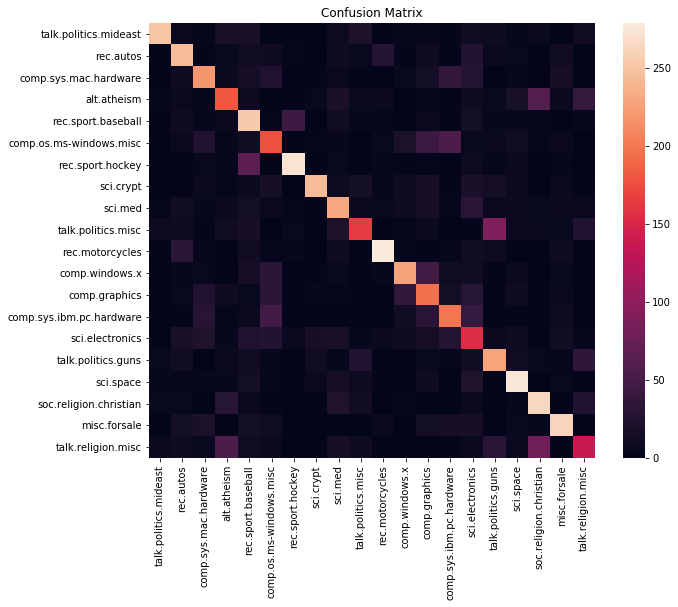

In [45]:
plt.figure(figsize=(10, 8))
plt.title("Confusion Matrix")
ticklabels = [v for k, v in classes.items()]
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=ticklabels, yticklabels = ticklabels)
xticklabels, yticklabels = True, True

In [102]:
# These are most important parameters
parameters  = {'max_depth':np.arange(5, 25, 5), # Took a few tries to find this range
               'min_child_weight':np.arange(1,3, 1)}
model       = xgb.XGBClassifier(learning_rate=0.1, n_estimators=20, objective='binary:logistic', seed=42)

grid_search = GridSearchCV(estimator=model, param_grid=parameters,
                           scoring='roc_auc', cv=3, verbose=50)

#y = label_binarize(y_train, classes=range(20))
grid_search.fit(X_train, y_train)
grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=5, min_child_weight=1 .................................


ValueError: bad input shape (5258, 20)

## 2.3 Topic Modelling
The model in its current form demonstrates what is possible when all of our data is labelled. now let's explore how we can soft cluster the data when the labels are withheld. 
<hr>

In [46]:
''' Convert python dictionary to gensim.corpora.Dictionary'''
all_tokens = []
for k in dic_train.keys():
        all_tokens.append([k])
dictionary = gensim.corpora.Dictionary(all_tokens)


It's necessary to recreate the tf-idf mappings in some way that the Gensim library can understand, to feed the LDA algorithm. Note that the mappings are identical to those created by the sklearn library. From an experimental perspective, this control is neccesary to compare models.

In [51]:
def create_tfidf_corpus(dictionary):
    bow_corpus = [dictionary.doc2bow(doc) for doc in df_train['processed_text'].tolist()]
    tfidf_model = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf_model[bow_corpus]
    return corpus_tfidf

corpus_tfidf = create_tfidf_corpus(dictionary)
print("For a random data point, the tf-idf mapping looks like: \n\n" + str(corpus_tfidf[1000]))


For a random data point, the tf-idf mapping looks like: 

[(5, 0.14049331632726408), (39, 0.08650108026883466), (120, 0.14472133354837335), (343, 0.3742777121960195), (432, 0.14007515978058832), (512, 0.20883990791722568), (517, 0.17609562820749658), (534, 0.13952286113877255), (551, 0.1740380789211301), (611, 0.2223952860059055), (739, 0.12425112456059481), (960, 0.18713885609800976), (1054, 0.26580050390596094), (1064, 0.15179749285082628), (1184, 0.19282115654117993), (1428, 0.16516884311683047), (1499, 0.16241559677071635), (1855, 0.1795693987065541), (1861, 0.22823000951551625), (1960, 0.26911541396008914), (2516, 0.47596458338881387)]


Each token has an integer key and a corresponding weighting.

In [49]:
''' Run lda algorithm on corpus to generate model'''
lda = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20, id2word=dictionary, passes=5,
                                       minimum_probability = 0.05)

for i, topic in lda.print_topics(-1, num_words=20):
    print('Topic: {} \nWords: {}\n'.format(i, topic))

Topic: 0 
Words: 0.002*"window" + 0.002*"know" + 0.002*"car" + 0.002*"thank" + 0.002*"use" + 0.002*"work" + 0.002*"like" + 0.002*"good" + 0.001*"think" + 0.001*"program" + 0.001*"say" + 0.001*"address" + 0.001*"run" + 0.001*"color" + 0.001*"new" + 0.001*"want" + 0.001*"time" + 0.001*"mode" + 0.001*"look" + 0.001*"year"

Topic: 1 
Words: 0.002*"thank" + 0.002*"cdt" + 0.002*"game" + 0.002*"tri" + 0.001*"year" + 0.001*"post" + 0.001*"know" + 0.001*"look" + 0.001*"time" + 0.001*"work" + 0.001*"like" + 0.001*"score" + 0.001*"window" + 0.001*"good" + 0.001*"team" + 0.001*"get" + 0.001*"drive" + 0.001*"think" + 0.001*"use" + 0.001*"driver"

Topic: 2 
Words: 0.003*"key" + 0.003*"encrypt" + 0.002*"chip" + 0.002*"cramer" + 0.002*"secur" + 0.002*"peopl" + 0.002*"govern" + 0.002*"know" + 0.002*"use" + 0.002*"law" + 0.002*"new" + 0.001*"good" + 0.001*"like" + 0.001*"think" + 0.001*"clipper" + 0.001*"window" + 0.001*"crypto" + 0.001*"right" + 0.001*"escrow" + 0.001*"time"

Topic: 3 
Words: 0.003*"go

In [52]:
'''Print a couple of sample vector embeddings'''
vectors = []
bow_corpus = [dictionary.doc2bow(doc) for doc in df_train['processed_text']]
for i in range(0, 6000, 200):
    vector = lda[bow_corpus[i]]
    vectors.append(vector)
pprint.pprint(vectors)

[[(5, 0.67874295), (13, 0.06328283), (18, 0.18290012)],
 [(19, 0.9568029)],
 [(4, 0.053307585),
  (5, 0.051188752),
  (8, 0.16711411),
  (11, 0.4420756),
  (12, 0.0783791)],
 [(4, 0.6106398), (8, 0.36116815)],
 [(3, 0.412599), (4, 0.4009665), (8, 0.10580623), (10, 0.07454508)],
 [(8, 0.9604029)],
 [(8, 0.5308554), (16, 0.43801963)],
 [(3, 0.5623741), (8, 0.40008998)],
 [(4, 0.13292828), (8, 0.24262966), (16, 0.6013138)],
 [(8, 0.5143407), (16, 0.19446018), (17, 0.28060645)],
 [(0, 0.23233396), (2, 0.1644503), (10, 0.1979714), (18, 0.37655982)],
 [(4, 0.8647798), (17, 0.11365934)],
 [(5, 0.17264444), (8, 0.8036352)],
 [(3, 0.5637019), (8, 0.21665008), (16, 0.20612678)],
 [(8, 0.33411998), (9, 0.60579365)],
 [(2, 0.6194408), (8, 0.3471739)],
 [(3, 0.3363222), (8, 0.61709785)],
 [(5, 0.26830238), (13, 0.7066667)],
 [(2, 0.89438045)],
 [(16, 0.16128393), (17, 0.7823454)],
 [(8, 0.49792194), (18, 0.47692773)],
 [(0, 0.95866334)],
 [(3, 0.177048), (4, 0.77557635)],
 [(7, 0.93665135)],
 [(4, 

<hr>
Looking good so far! The topics, by cursory inspection, appear to denote semantically distinct topics. Also, testing an arbitrary sample of datapoints, it's clear that the data is mostly distributed between only a small number of clusters (1-3). (The minimum_probability=0.05 setting in the LDA model ignores contributions which are too small.)

This is a good indicator that the LDA algorithm has identified the semantic structures within the data which separate the classes.
<hr>

<script type="text/x-mathjax-config">MathJax.Hub.Config({tex2jax: {inlineMath:[['$','$']]}});</script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=default' async></script>

## 2.4 Concealing the Labels, and Sampling Down the Data
Now it's time to train classifiers on subsets of the training set, and compare how the raw classifier compares to classifiers trained on the topic embeddings of the data. This will allow us to build the "relative accuracy" metric, defined as: $acc_r=\dfrac{acc_n - acc_t}{1-acc_t}$, where $acc_n$ is the accuracy of the classifier built with topic embeddings, and $acc_t$ is the accuracy of the classifeier built on tf-idf embeddings.

In [62]:
''' Utilities for preparing data for experimental method comparison '''

# Sample data, partially maintaining stratification
def sample_data(data, sample_size=0.1):
    max_sample_size = max(data['class'].value_counts())
    sampled_data = data.groupby('class', group_keys=False).apply(lambda x: x.sample(min(len(x), int(max_sample_size*sample_size)), random_state=42))
    return sampled_data

# Feed a datapoint, return 20-D topic embedding
def vector_to_embedding(datapoint, lda_model):
    vector = lda_model[datapoint]
    embedding = np.zeros(20)
    for elem in vector:
        embedding[elem[0]] = elem[1]
    return embedding

def embed_data(sampled_data, lda_model):
    columns = ['topic_{}'.format(i) for i in range(1, 21)]
    embeddings = []
    for i in sampled_data['bow_text'].tolist():
        embedding = vector_to_embedding(i, lda)
        embeddings.append(embedding)
    embeddings = pd.DataFrame(embeddings, columns=columns)
    
    embedded_data = sampled_data.merge(embeddings, left_index=True, right_index=True)
    return embedded_data
    

In [69]:
'''Create a dataset of tf-idf embeddings, create one of topic embeddings''' 


df_train['bow_text'] = [dictionary.doc2bow(doc) for doc in df_train['processed_text']]
df_test['bow_text'] = [dictionary.doc2bow(doc) for doc in df_test['processed_text']]


df_train_sampled = sample_data(df_train, 0.2)
embedded_data_train = embed_data(df_train_sampled, lda)

df_test_sampled = sample_data(df_test, 0.2)
embedded_data_test = embed_data(df_test_sampled, lda)

embedded_data_train.head()

,text,class,source,processed_text,bow_text,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
1599,\nI will try to answer some of Dorin's questio...,0,train,"[tri, answer, dorin, question, address, specif...","[(1, 1), (10, 1), (11, 1), (18, 2), (19, 1), (...",0.0,0.0,0.0,0.000000,0.086946,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
187,\nThe Greeks did try to invade Cyprus just bef...,0,train,"[greek, tri, invad, cypru, turkish, intervent,...","[(90, 1), (475, 1), (776, 1), (855, 1), (2370,...",0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.559936,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2123,\n This is the latest from UPI \n Foreign...,0,train,"[late, upi, foreign, ministri, spokesman, ferh...","[(60, 1), (78, 1), (87, 1), (118, 1), (188, 1)...",0.0,0.0,0.0,0.246766,0.382076,...,0.0,0.000000,0.000000,0.0,0.0,0.349765,0.0,0.0,0.0,0.0
1362,\nDon't swallow propaganda as truth Sir. Briti...,0,train,"[swallow, propaganda, truth, sir, british, pro...","[(18, 1), (24, 2), (37, 3), (39, 1), (43, 1), ...",0.0,0.0,0.0,0.238983,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
113,\nThe donations are tax deductible like any do...,0,train,"[donat, tax, deduct, like, donat, non-profit, ...","[(20, 1), (49, 1), (130, 1), (340, 1), (485, 1...",0.0,0.0,0.0,0.315975,0.000000,...,0.0,0.109086,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Great, the data is looking good. Time for some classification. It's worth noting at this point that the tf-idf mappings and the topic model embeddings applied to the test set were built on only the training sets. Though in practical application, these mappings and embeddings could include test set info, it would skew model results. For the tf-idf mappings it would re-weight the features in the train set, and for the topic model embeddings it would potentially intorduce new topics which were unaccounted for in the initial selection of k=20 topics.
<hr>

## 2.5 Twin Classifiers: tf-idf Mappings vs Topic Embeddings
Let's see how the two methods of encoding unstructured data fair against eachother, for an arbitrary subset of the total data.
<hr>

In [70]:
'''Create classifier and train on both data types'''


'''Start with subsampled TFIDF'''

dic_train = generate_vocabulary(embedded_data_train['processed_text'])
dic_test = generate_vocabulary(embedded_data_test['processed_text'])


vectorizer = TfidfVectorizer(vocabulary=dic_train)
vectorizer.fit_transform(df_train.text)
X_train, y_train = vectorizer.transform(embedded_data_train.text), embedded_data_train['class']
X_test , y_test  = vectorizer.transform(embedded_data_test.text) , embedded_data_test['class']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_sample = xgb.XGBClassifier(objective='multi:softmax', random_state=42, max_depth=10)
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], verbose=10)

y_pred  = model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print("Model accuracy: {}".format(acc))
print(classification_report(y_test, y_pred))




[0]	validation_0-merror:0.854701
Will train until validation_0-merror hasn't improved in 50 rounds.
[10]	validation_0-merror:0.769231
[20]	validation_0-merror:0.717949
[30]	validation_0-merror:0.700855
[40]	validation_0-merror:0.692308
[50]	validation_0-merror:0.692308
[60]	validation_0-merror:0.683761
[70]	validation_0-merror:0.692308
[80]	validation_0-merror:0.709402
Stopping. Best iteration:
[37]	validation_0-merror:0.683761

Model accuracy: 0.317351598173516
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        25
           1       0.28      0.39      0.33        18
           2       0.40      0.13      0.20        31
           3       0.09      0.17      0.11        12
           4       0.25      0.20      0.22        25
           5       0.26      0.39      0.31        18
           6       0.38      0.36      0.37        22
           7       0.80      0.43      0.56        28
           8       0.20      0.24      0.22   

In [74]:
'''Now using Topic Embeddings'''


X_train, y_train = embedded_data_train[embedded_data_train.columns[5:]], embedded_data_train['class']
X_test, y_test = embedded_data_test[embedded_data_train.columns[5:]], embedded_data_test['class']


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_lda = xgb.XGBClassifier(objective='multi:softmax', random_state=42, max_depth=10)
model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_val, y_val)], verbose=10)

y_pred  = model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print("Model accuracy: {}".format(acc))
print(classification_report(y_test, y_pred))

[0]	validation_0-merror:0.957265
Will train until validation_0-merror hasn't improved in 50 rounds.
[10]	validation_0-merror:0.982906
[20]	validation_0-merror:0.982906
[30]	validation_0-merror:0.965812
[40]	validation_0-merror:0.982906
[50]	validation_0-merror:0.957265
Stopping. Best iteration:
[0]	validation_0-merror:0.957265

Model accuracy: 0.06621004566210045
              precision    recall  f1-score   support

           0       0.07      0.12      0.09        25
           1       0.00      0.00      0.00        18
           2       0.12      0.03      0.05        31
           3       0.04      0.17      0.07        12
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        18
           6       0.09      0.09      0.09        22
           7       0.00      0.00      0.00        28
           8       0.14      0.07      0.09        29
           9       0.02      0.06      0.03        16
          10       0.18      0.09      

## Saving the LDA Model for Later



In [75]:
lda.save('lda_model')
dictionary.save_as_text('lda_dict.txt')

'How to Load it Back In'
# gensim.models.LdaModel.load('lda_model')
# gensim.corpora.dictionary.Dictionary.load_from_text('lda_dict.txt')